### Урок 7. Классификация с помощью kNN.

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
X, y = load_iris(return_X_y=True)
# Возьмем первые три признака (всего в датасете их 4)
X = X[:, :3]

In [3]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=1)

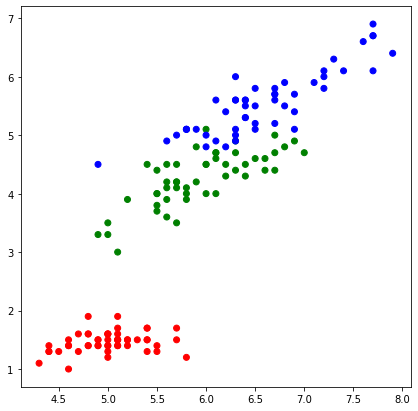

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 2], c=y, cmap=cmap)

#### __1__. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [5]:
# Функция подсчёта Евклидовой метрики
def e_metrics(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

В качестве веса возьмем $w(d)=q^{d}, \space q=0.5$

In [6]:
# Алгоритм поиска k ближайших соседей
def knn(x_train, y_train, x_test, k):
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем "вес" каждого класса, зависимый от расстояния
        for d in sorted(test_distances)[0:k]:
            #classes[d[1]] += 1
            classes[d[1]] += 0.5**d[0]
            
        # Записываем в список ответов наиболее "весомый" класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [7]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [8]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.6f}')

Точность алгоритма при k = 5: 0.921053


#### __2__. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [9]:
from sklearn.datasets import make_blobs
import random

# Сгенерируем три облака точек
X, y = make_blobs(n_samples=100, random_state=37)

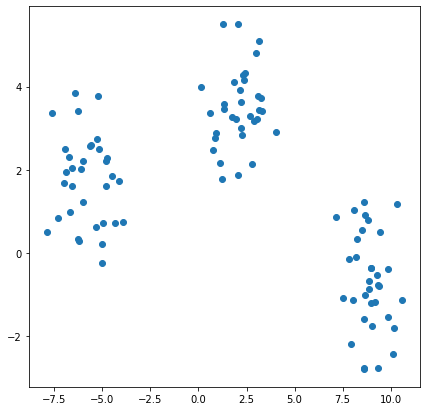

In [10]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

В качестве метрики расстояния будем использовать Eвклидово расстояние.   
В качестве центроидов выберем первые k элементов датасета.

In [11]:
def kmeans(data, k, max_iterations, min_distance):    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}
        
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [12]:
# Метрика качества кластеризации как среднее квадратичное внутриклассовое расстояние
def clust_quality_metric(centroids, classes):
    ss = 0
    n = 0
    for i, centroid in enumerate(centroids):
        for x in classes[i]:
            ss += e_metrics(centroid, x)**2
            n += 1
    
    return np.sqrt(ss/n)

In [13]:
# определим максимальное количество итераций
max_iterations = 7
# минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4
# определим количество кластеров
kls = [x for x in range(1, 11)]

In [14]:
metrics = []
for k in kls:
    centroids, classes = kmeans(X, k, max_iterations, min_distance)
    metrics.append(clust_quality_metric(centroids, classes))

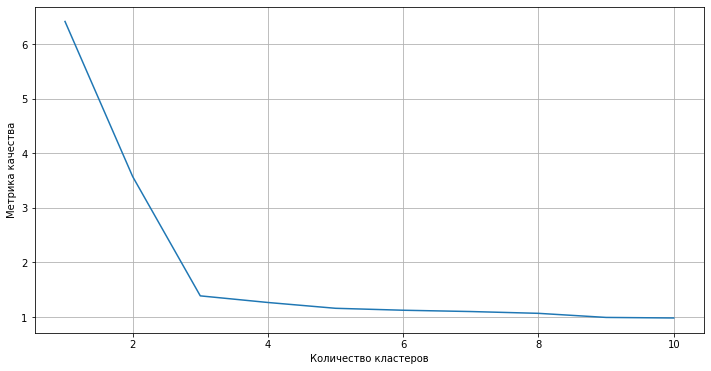

In [15]:
plt.figure(figsize=(12,6))
plt.xlabel("Количество кластеров")
plt.ylabel("Метрика качества")
plt.grid()
plt.plot(kls, metrics)

In [16]:
metrics

[6.417575750330452,
 3.575153079300203,
 1.3876200932537477,
 1.2662085068834348,
 1.1597736472046676,
 1.1241016176469434,
 1.1002512695461164,
 1.0673122492971883,
 0.9923118023566013,
 0.9823111714420719]